In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [2]:
def getFormat(df, train_raw, window_size, stride):
    x = []
    for i in df:
        x.append(train_raw[i + 750 : i + 1750])
    x = np.array(x)
    x = x.reshape(-1, x.shape[2])
    upsample = []
    for i in range(0, len(x), stride):
        if(i + window_size <= len(x)):
            upsample.append(np.array(x[i: i + window_size]))
    return np.array(upsample)

def getData(subject, window_size, stride):
    train_raw = pd.read_csv("data/" + subject + "_data.csv", header=None).fillna(method='ffill').values
    print(train_raw.shape)
    markers_raw = pd.read_csv("data/" + subject + "_markers.csv", header=None)
    markers_raw.dropna(inplace=True)
    markers_raw.reset_index(drop=True, inplace=True)
    
    mr1 = markers_raw[markers_raw[1] == 1][0]
    mr2 = markers_raw[markers_raw[1] == 2][0]
    mr3 = markers_raw[markers_raw[1] == 3][0]
    mr4 = markers_raw[markers_raw[1] == 4][0]
  
    X1, X2, X3, X4 = [getFormat(mr, train_raw, window_size, stride) for mr in [mr1, mr2, mr3, mr4]]
    Y = [0] * len(X1) + [1] * len(X2) + [2] * len(X3) + [3] * len(X4)
  
  
    X = np.append(X1, X2, axis = 0)
    X = np.append(X, X3, axis = 0)
    X = np.append(X, X4, axis = 0)
  
    print(X.shape)
    scalers = {}
    for i in range(X.shape[2]):
        scalers[i] = preprocessing.StandardScaler()
        X[:, :, i] = scalers[i].fit_transform(X[:, :, i])
  
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

    return X, Y

In [3]:
def getReport(y_train, y_test, y_tr_pred, y_pred):
    accuracy = accuracy_score(np.argmax(y_pred, axis=1), y_test)
    tr_accuracy = accuracy_score(np.argmax(y_tr_pred, axis=1), y_train)
    precision = precision_score(np.argmax(y_pred, axis=1), y_test, average=None)
    recall = recall_score(np.argmax(y_pred, axis=1), y_test, average=None)
    f1 = f1_score(np.argmax(y_pred, axis=1),y_test, average=None)
    rmse = mean_squared_error(np.argmax(y_pred, axis=1),y_test)
    print({"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1})

    return accuracy, tr_accuracy, precision, recall, f1, rmse

In [4]:
def createmodel(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), kernel_initializer=initializers.he_normal(), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))    
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=initializers.he_normal()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))    
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initializers.he_normal()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax', kernel_initializer=initializers.he_normal()))

    model.summary()
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [5]:
def cnn(subject, X_train, X_test, y_train, y_test, epochs=200, batch=128):
    input_shape = X_train[0].shape
    model = createmodel(input_shape)
    filepath="weights/CNN/new/16-0.5-32-0.5-64-0.5--" + subject + "-weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch,
                            shuffle=True,
                            validation_data=[X_test, y_test],
                            callbacks=callbacks_list,
                            verbose=2)
    bestmodel = load_model(filepath)
    return bestmodel

In [6]:
def runmodel(subject, epochs=200, batch=64, window_size=125, stride=100):
    X, y = getData(subject, window_size=window_size, stride=stride)
    y = np.array(y)
    seed = 7
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    tr_acc, acc, pre, rec, f, rms = 0, 0, 0, 0, 0, 0
    for train, test in kfold.split(X, y):
        y_train = to_categorical(y[train])
        y_test = to_categorical(y[test])
        model = cnn(subject, X[train], 
                              X[test], 
                              y_train, 
                              y_test, epochs, batch)
        y_pred = model.predict(X[test])
        y_tr_pred = model.predict(X[train])

        accuracy, tr_accuracy, precision, recall, f1, rmse = getReport(y[train], y[test], y_tr_pred, y_pred)
        return {"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1}
        rms = rms + rmse / 10
        tr_acc = tr_acc + tr_accuracy / 10
        acc = acc + accuracy / 10
        rec = rec + recall / 10
        pre = pre + precision / 10
        f = f + f1 / 10
        break
    return {"rmse": rms, "tr_acc": tr_acc, "acc": acc, "pre": pre, "rec": rec, "f1s": f}

In [7]:
reports = []
for subject in ['k3b', 'k6b', 'l1b'] :
    report = {
      "subject": subject,
      "report": runmodel(subject, epochs=500, batch=64, window_size=125, stride=100)
    }
    reports.append(report)

(986780, 60)
(1796, 125, 60)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 60, 16)       160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 60, 16)       64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 30, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 30, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 30, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 15, 32)


Epoch 00038: val_acc did not improve from 0.46111
Epoch 39/500
 - 50s - loss: 1.2941 - acc: 0.4938 - val_loss: 1.3201 - val_acc: 0.4500

Epoch 00039: val_acc did not improve from 0.46111
Epoch 40/500
 - 46s - loss: 1.2714 - acc: 0.5080 - val_loss: 1.3696 - val_acc: 0.4556

Epoch 00040: val_acc did not improve from 0.46111
Epoch 41/500
 - 43s - loss: 1.2499 - acc: 0.5093 - val_loss: 1.3484 - val_acc: 0.4278

Epoch 00041: val_acc did not improve from 0.46111
Epoch 42/500
 - 53s - loss: 1.1939 - acc: 0.5365 - val_loss: 1.2765 - val_acc: 0.4722

Epoch 00042: val_acc improved from 0.46111 to 0.47222, saving model to weights/CNN/new/16-0.5-32-0.5-64-0.5--k3b-weights.hdf5
Epoch 43/500
 - 46s - loss: 1.1616 - acc: 0.5223 - val_loss: 1.2995 - val_acc: 0.4556

Epoch 00043: val_acc did not improve from 0.47222
Epoch 44/500
 - 37s - loss: 1.2243 - acc: 0.4994 - val_loss: 1.3043 - val_acc: 0.4667

Epoch 00044: val_acc did not improve from 0.47222
Epoch 45/500
 - 39s - loss: 1.2245 - acc: 0.5080 - 

 - 50s - loss: 0.7622 - acc: 0.6869 - val_loss: 1.4262 - val_acc: 0.5000

Epoch 00096: val_acc did not improve from 0.55000
Epoch 97/500
 - 48s - loss: 0.7615 - acc: 0.6906 - val_loss: 1.5040 - val_acc: 0.5167

Epoch 00097: val_acc did not improve from 0.55000
Epoch 98/500
 - 51s - loss: 0.7168 - acc: 0.6937 - val_loss: 1.4477 - val_acc: 0.5000

Epoch 00098: val_acc did not improve from 0.55000
Epoch 99/500
 - 50s - loss: 0.7459 - acc: 0.6887 - val_loss: 1.4714 - val_acc: 0.5000

Epoch 00099: val_acc did not improve from 0.55000
Epoch 100/500
 - 50s - loss: 0.7614 - acc: 0.6844 - val_loss: 1.4695 - val_acc: 0.5278

Epoch 00100: val_acc did not improve from 0.55000
Epoch 101/500
 - 49s - loss: 0.6725 - acc: 0.7209 - val_loss: 1.4934 - val_acc: 0.5056

Epoch 00101: val_acc did not improve from 0.55000
Epoch 102/500
 - 49s - loss: 0.7363 - acc: 0.6918 - val_loss: 1.4872 - val_acc: 0.5111

Epoch 00102: val_acc did not improve from 0.55000
Epoch 103/500
 - 49s - loss: 0.7265 - acc: 0.7073 -

 - 51s - loss: 0.5279 - acc: 0.7778 - val_loss: 1.5925 - val_acc: 0.5111

Epoch 00155: val_acc did not improve from 0.56111
Epoch 156/500
 - 49s - loss: 0.4644 - acc: 0.8075 - val_loss: 1.6544 - val_acc: 0.5222

Epoch 00156: val_acc did not improve from 0.56111
Epoch 157/500
 - 49s - loss: 0.4642 - acc: 0.8162 - val_loss: 1.6350 - val_acc: 0.4889

Epoch 00157: val_acc did not improve from 0.56111
Epoch 158/500
 - 49s - loss: 0.4957 - acc: 0.8088 - val_loss: 1.6941 - val_acc: 0.4833

Epoch 00158: val_acc did not improve from 0.56111
Epoch 159/500
 - 49s - loss: 0.4596 - acc: 0.8175 - val_loss: 1.7445 - val_acc: 0.5222

Epoch 00159: val_acc did not improve from 0.56111
Epoch 160/500
 - 49s - loss: 0.4863 - acc: 0.8057 - val_loss: 1.7953 - val_acc: 0.5056

Epoch 00160: val_acc did not improve from 0.56111
Epoch 161/500
 - 49s - loss: 0.4672 - acc: 0.8094 - val_loss: 1.6891 - val_acc: 0.5389

Epoch 00161: val_acc did not improve from 0.56111
Epoch 162/500
 - 51s - loss: 0.4961 - acc: 0.811

 - 49s - loss: 0.3515 - acc: 0.8663 - val_loss: 1.6902 - val_acc: 0.5667

Epoch 00214: val_acc did not improve from 0.57222
Epoch 215/500
 - 48s - loss: 0.3612 - acc: 0.8713 - val_loss: 1.6256 - val_acc: 0.5611

Epoch 00215: val_acc did not improve from 0.57222
Epoch 216/500
 - 49s - loss: 0.3371 - acc: 0.8719 - val_loss: 1.6535 - val_acc: 0.5389

Epoch 00216: val_acc did not improve from 0.57222
Epoch 217/500
 - 50s - loss: 0.3437 - acc: 0.8632 - val_loss: 1.7362 - val_acc: 0.5611

Epoch 00217: val_acc did not improve from 0.57222
Epoch 218/500
 - 49s - loss: 0.3527 - acc: 0.8639 - val_loss: 1.7036 - val_acc: 0.5389

Epoch 00218: val_acc did not improve from 0.57222
Epoch 219/500
 - 49s - loss: 0.3674 - acc: 0.8645 - val_loss: 1.6626 - val_acc: 0.5333

Epoch 00219: val_acc did not improve from 0.57222
Epoch 220/500
 - 49s - loss: 0.3446 - acc: 0.8608 - val_loss: 1.7525 - val_acc: 0.5167

Epoch 00220: val_acc did not improve from 0.57222
Epoch 221/500
 - 50s - loss: 0.3669 - acc: 0.855


Epoch 00272: val_acc did not improve from 0.58889
Epoch 273/500
 - 42s - loss: 0.3509 - acc: 0.8688 - val_loss: 1.7486 - val_acc: 0.5556

Epoch 00273: val_acc did not improve from 0.58889
Epoch 274/500
 - 40s - loss: 0.2952 - acc: 0.8917 - val_loss: 1.7969 - val_acc: 0.5444

Epoch 00274: val_acc did not improve from 0.58889
Epoch 275/500
 - 42s - loss: 0.2950 - acc: 0.8849 - val_loss: 1.7097 - val_acc: 0.5500

Epoch 00275: val_acc did not improve from 0.58889
Epoch 276/500
 - 43s - loss: 0.2958 - acc: 0.8880 - val_loss: 1.8024 - val_acc: 0.5500

Epoch 00276: val_acc did not improve from 0.58889
Epoch 277/500
 - 49s - loss: 0.3260 - acc: 0.8688 - val_loss: 1.8342 - val_acc: 0.5556

Epoch 00277: val_acc did not improve from 0.58889
Epoch 278/500
 - 54s - loss: 0.3381 - acc: 0.8713 - val_loss: 1.7851 - val_acc: 0.5778

Epoch 00278: val_acc did not improve from 0.58889
Epoch 279/500
 - 62s - loss: 0.2803 - acc: 0.8874 - val_loss: 1.8018 - val_acc: 0.5556

Epoch 00279: val_acc did not impr

 - 56s - loss: 0.3065 - acc: 0.8917 - val_loss: 1.8123 - val_acc: 0.5389

Epoch 00332: val_acc did not improve from 0.58889
Epoch 333/500
 - 40s - loss: 0.2573 - acc: 0.9053 - val_loss: 1.7722 - val_acc: 0.5500

Epoch 00333: val_acc did not improve from 0.58889
Epoch 334/500
 - 50s - loss: 0.2776 - acc: 0.8991 - val_loss: 1.9332 - val_acc: 0.5278

Epoch 00334: val_acc did not improve from 0.58889
Epoch 335/500
 - 45s - loss: 0.2508 - acc: 0.9041 - val_loss: 1.8328 - val_acc: 0.5667

Epoch 00335: val_acc did not improve from 0.58889
Epoch 336/500
 - 40s - loss: 0.2630 - acc: 0.9004 - val_loss: 1.8388 - val_acc: 0.5500

Epoch 00336: val_acc did not improve from 0.58889
Epoch 337/500
 - 50s - loss: 0.2823 - acc: 0.8985 - val_loss: 1.8299 - val_acc: 0.5500

Epoch 00337: val_acc did not improve from 0.58889
Epoch 338/500
 - 47s - loss: 0.2477 - acc: 0.9053 - val_loss: 1.8932 - val_acc: 0.5722

Epoch 00338: val_acc did not improve from 0.58889
Epoch 339/500
 - 44s - loss: 0.2413 - acc: 0.917

 - 101s - loss: 0.2576 - acc: 0.9121 - val_loss: 1.8289 - val_acc: 0.5611

Epoch 00391: val_acc did not improve from 0.58889
Epoch 392/500
 - 84s - loss: 0.2337 - acc: 0.9158 - val_loss: 1.8224 - val_acc: 0.5667

Epoch 00392: val_acc did not improve from 0.58889
Epoch 393/500
 - 94s - loss: 0.2551 - acc: 0.9028 - val_loss: 1.8899 - val_acc: 0.5611

Epoch 00393: val_acc did not improve from 0.58889
Epoch 394/500
 - 93s - loss: 0.2227 - acc: 0.9158 - val_loss: 1.7610 - val_acc: 0.5667

Epoch 00394: val_acc did not improve from 0.58889
Epoch 395/500
 - 64s - loss: 0.2388 - acc: 0.9189 - val_loss: 1.8045 - val_acc: 0.5556

Epoch 00395: val_acc did not improve from 0.58889
Epoch 396/500
 - 66s - loss: 0.2463 - acc: 0.9146 - val_loss: 1.7881 - val_acc: 0.5889

Epoch 00396: val_acc did not improve from 0.58889
Epoch 397/500
 - 65s - loss: 0.2003 - acc: 0.9264 - val_loss: 1.7843 - val_acc: 0.5889

Epoch 00397: val_acc improved from 0.58889 to 0.58889, saving model to weights/CNN/new/16-0.5-32-

 - 49s - loss: 0.1981 - acc: 0.9202 - val_loss: 1.8385 - val_acc: 0.5556

Epoch 00450: val_acc did not improve from 0.58889
Epoch 451/500
 - 51s - loss: 0.2196 - acc: 0.9158 - val_loss: 1.8783 - val_acc: 0.5333

Epoch 00451: val_acc did not improve from 0.58889
Epoch 452/500
 - 49s - loss: 0.2150 - acc: 0.9202 - val_loss: 1.9164 - val_acc: 0.5500

Epoch 00452: val_acc did not improve from 0.58889
Epoch 453/500
 - 61s - loss: 0.2246 - acc: 0.9165 - val_loss: 1.8851 - val_acc: 0.5667

Epoch 00453: val_acc did not improve from 0.58889
Epoch 454/500
 - 59s - loss: 0.2343 - acc: 0.9152 - val_loss: 1.9538 - val_acc: 0.5444

Epoch 00454: val_acc did not improve from 0.58889
Epoch 455/500
 - 39s - loss: 0.2066 - acc: 0.9239 - val_loss: 1.9163 - val_acc: 0.5667

Epoch 00455: val_acc did not improve from 0.58889
Epoch 456/500
 - 39s - loss: 0.2111 - acc: 0.9239 - val_loss: 1.9775 - val_acc: 0.5611

Epoch 00456: val_acc did not improve from 0.58889
Epoch 457/500
 - 47s - loss: 0.2071 - acc: 0.925

Train on 1076 samples, validate on 120 samples
Epoch 1/500
 - 28s - loss: 3.7368 - acc: 0.2491 - val_loss: 1.5007 - val_acc: 0.2500

Epoch 00001: val_acc improved from -inf to 0.25000, saving model to weights/CNN/new/16-0.5-32-0.5-64-0.5--k6b-weights.hdf5
Epoch 2/500
 - 28s - loss: 3.0318 - acc: 0.2835 - val_loss: 1.4098 - val_acc: 0.3083

Epoch 00002: val_acc improved from 0.25000 to 0.30833, saving model to weights/CNN/new/16-0.5-32-0.5-64-0.5--k6b-weights.hdf5
Epoch 3/500
 - 37s - loss: 2.7373 - acc: 0.3011 - val_loss: 1.5005 - val_acc: 0.2833

Epoch 00003: val_acc did not improve from 0.30833
Epoch 4/500
 - 28s - loss: 2.7647 - acc: 0.3262 - val_loss: 1.5411 - val_acc: 0.3000

Epoch 00004: val_acc did not improve from 0.30833
Epoch 5/500
 - 30s - loss: 2.6256 - acc: 0.3076 - val_loss: 1.4982 - val_acc: 0.3417

Epoch 00005: val_acc improved from 0.30833 to 0.34167, saving model to weights/CNN/new/16-0.5-32-0.5-64-0.5--k6b-weights.hdf5
Epoch 6/500
 - 28s - loss: 2.4344 - acc: 0.3336 

 - 28s - loss: 1.1835 - acc: 0.5186 - val_loss: 1.7504 - val_acc: 0.3667

Epoch 00058: val_acc did not improve from 0.41667
Epoch 59/500
 - 27s - loss: 1.2299 - acc: 0.5000 - val_loss: 1.7951 - val_acc: 0.3167

Epoch 00059: val_acc did not improve from 0.41667
Epoch 60/500
 - 25s - loss: 1.1888 - acc: 0.5251 - val_loss: 1.7507 - val_acc: 0.3167

Epoch 00060: val_acc did not improve from 0.41667
Epoch 61/500
 - 26s - loss: 1.1747 - acc: 0.5270 - val_loss: 1.8024 - val_acc: 0.3417

Epoch 00061: val_acc did not improve from 0.41667
Epoch 62/500
 - 24s - loss: 1.2008 - acc: 0.5204 - val_loss: 1.9076 - val_acc: 0.3500

Epoch 00062: val_acc did not improve from 0.41667
Epoch 63/500
 - 24s - loss: 1.2288 - acc: 0.5139 - val_loss: 1.8911 - val_acc: 0.3250

Epoch 00063: val_acc did not improve from 0.41667
Epoch 64/500
 - 24s - loss: 1.1293 - acc: 0.5381 - val_loss: 1.8955 - val_acc: 0.3333

Epoch 00064: val_acc did not improve from 0.41667
Epoch 65/500
 - 24s - loss: 1.1491 - acc: 0.5483 - val

 - 24s - loss: 0.7922 - acc: 0.6710 - val_loss: 2.0731 - val_acc: 0.3333

Epoch 00118: val_acc did not improve from 0.41667
Epoch 119/500
 - 25s - loss: 0.7620 - acc: 0.6887 - val_loss: 1.9923 - val_acc: 0.3500

Epoch 00119: val_acc did not improve from 0.41667
Epoch 120/500
 - 24s - loss: 0.8078 - acc: 0.6794 - val_loss: 1.9743 - val_acc: 0.3750

Epoch 00120: val_acc did not improve from 0.41667
Epoch 121/500
 - 24s - loss: 0.7264 - acc: 0.7026 - val_loss: 2.0471 - val_acc: 0.3583

Epoch 00121: val_acc did not improve from 0.41667
Epoch 122/500
 - 24s - loss: 0.8322 - acc: 0.6803 - val_loss: 2.0779 - val_acc: 0.3333

Epoch 00122: val_acc did not improve from 0.41667
Epoch 123/500
 - 24s - loss: 0.7390 - acc: 0.7072 - val_loss: 2.0665 - val_acc: 0.3583

Epoch 00123: val_acc did not improve from 0.41667
Epoch 124/500
 - 24s - loss: 0.7828 - acc: 0.6849 - val_loss: 2.0226 - val_acc: 0.3333

Epoch 00124: val_acc did not improve from 0.41667
Epoch 125/500
 - 24s - loss: 0.7838 - acc: 0.682


Epoch 00177: val_acc did not improve from 0.41667
Epoch 178/500
 - 24s - loss: 0.5609 - acc: 0.7797 - val_loss: 2.3214 - val_acc: 0.3417

Epoch 00178: val_acc did not improve from 0.41667
Epoch 179/500
 - 24s - loss: 0.5101 - acc: 0.7974 - val_loss: 2.3316 - val_acc: 0.3333

Epoch 00179: val_acc did not improve from 0.41667
Epoch 180/500
 - 24s - loss: 0.5337 - acc: 0.7918 - val_loss: 2.3512 - val_acc: 0.3417

Epoch 00180: val_acc did not improve from 0.41667
Epoch 181/500
 - 24s - loss: 0.4955 - acc: 0.8104 - val_loss: 2.3653 - val_acc: 0.3583

Epoch 00181: val_acc did not improve from 0.41667
Epoch 182/500
 - 24s - loss: 0.5501 - acc: 0.7797 - val_loss: 2.4479 - val_acc: 0.3667

Epoch 00182: val_acc did not improve from 0.41667
Epoch 183/500
 - 24s - loss: 0.5233 - acc: 0.7974 - val_loss: 2.4301 - val_acc: 0.3667

Epoch 00183: val_acc did not improve from 0.41667
Epoch 184/500
 - 24s - loss: 0.5362 - acc: 0.7900 - val_loss: 2.4222 - val_acc: 0.3667

Epoch 00184: val_acc did not impr

 - 24s - loss: 0.3635 - acc: 0.8541 - val_loss: 2.8965 - val_acc: 0.3000

Epoch 00237: val_acc did not improve from 0.41667
Epoch 238/500
 - 24s - loss: 0.3814 - acc: 0.8578 - val_loss: 3.0038 - val_acc: 0.3333

Epoch 00238: val_acc did not improve from 0.41667
Epoch 239/500
 - 24s - loss: 0.3959 - acc: 0.8550 - val_loss: 3.0117 - val_acc: 0.3250

Epoch 00239: val_acc did not improve from 0.41667
Epoch 240/500
 - 25s - loss: 0.4509 - acc: 0.8364 - val_loss: 2.9086 - val_acc: 0.3417

Epoch 00240: val_acc did not improve from 0.41667
Epoch 241/500
 - 24s - loss: 0.3857 - acc: 0.8448 - val_loss: 2.9234 - val_acc: 0.3167

Epoch 00241: val_acc did not improve from 0.41667
Epoch 242/500
 - 24s - loss: 0.3840 - acc: 0.8662 - val_loss: 2.9935 - val_acc: 0.3500

Epoch 00242: val_acc did not improve from 0.41667
Epoch 243/500
 - 24s - loss: 0.3915 - acc: 0.8559 - val_loss: 3.0298 - val_acc: 0.3250

Epoch 00243: val_acc did not improve from 0.41667
Epoch 244/500
 - 25s - loss: 0.4009 - acc: 0.842


Epoch 00296: val_acc did not improve from 0.41667
Epoch 297/500
 - 24s - loss: 0.3239 - acc: 0.8922 - val_loss: 3.1535 - val_acc: 0.3667

Epoch 00297: val_acc did not improve from 0.41667
Epoch 298/500
 - 24s - loss: 0.3382 - acc: 0.8690 - val_loss: 3.1584 - val_acc: 0.3333

Epoch 00298: val_acc did not improve from 0.41667
Epoch 299/500
 - 24s - loss: 0.3315 - acc: 0.8820 - val_loss: 3.2027 - val_acc: 0.3333

Epoch 00299: val_acc did not improve from 0.41667
Epoch 300/500
 - 24s - loss: 0.2888 - acc: 0.8903 - val_loss: 3.2128 - val_acc: 0.3417

Epoch 00300: val_acc did not improve from 0.41667
Epoch 301/500
 - 24s - loss: 0.3040 - acc: 0.8857 - val_loss: 3.2068 - val_acc: 0.3417

Epoch 00301: val_acc did not improve from 0.41667
Epoch 302/500
 - 24s - loss: 0.3005 - acc: 0.8792 - val_loss: 3.0836 - val_acc: 0.3250

Epoch 00302: val_acc did not improve from 0.41667
Epoch 303/500
 - 24s - loss: 0.3406 - acc: 0.8708 - val_loss: 2.9913 - val_acc: 0.3500

Epoch 00303: val_acc did not impr

 - 24s - loss: 0.2805 - acc: 0.9006 - val_loss: 3.3670 - val_acc: 0.3583

Epoch 00356: val_acc did not improve from 0.41667
Epoch 357/500
 - 25s - loss: 0.2459 - acc: 0.9080 - val_loss: 3.4709 - val_acc: 0.3583

Epoch 00357: val_acc did not improve from 0.41667
Epoch 358/500
 - 24s - loss: 0.2616 - acc: 0.8950 - val_loss: 3.5379 - val_acc: 0.3250

Epoch 00358: val_acc did not improve from 0.41667
Epoch 359/500
 - 24s - loss: 0.2345 - acc: 0.9136 - val_loss: 3.5780 - val_acc: 0.3083

Epoch 00359: val_acc did not improve from 0.41667
Epoch 360/500
 - 25s - loss: 0.2792 - acc: 0.9006 - val_loss: 3.5915 - val_acc: 0.3250

Epoch 00360: val_acc did not improve from 0.41667
Epoch 361/500
 - 24s - loss: 0.2414 - acc: 0.9117 - val_loss: 3.4739 - val_acc: 0.3333

Epoch 00361: val_acc did not improve from 0.41667
Epoch 362/500
 - 24s - loss: 0.2898 - acc: 0.8885 - val_loss: 3.4429 - val_acc: 0.3500

Epoch 00362: val_acc did not improve from 0.41667
Epoch 363/500
 - 24s - loss: 0.2338 - acc: 0.908


Epoch 00415: val_acc did not improve from 0.41667
Epoch 416/500
 - 25s - loss: 0.2337 - acc: 0.9154 - val_loss: 3.4856 - val_acc: 0.3250

Epoch 00416: val_acc did not improve from 0.41667
Epoch 417/500
 - 24s - loss: 0.2822 - acc: 0.8959 - val_loss: 3.5495 - val_acc: 0.3333

Epoch 00417: val_acc did not improve from 0.41667
Epoch 418/500
 - 24s - loss: 0.2322 - acc: 0.9219 - val_loss: 3.5589 - val_acc: 0.3667

Epoch 00418: val_acc did not improve from 0.41667
Epoch 419/500
 - 24s - loss: 0.2268 - acc: 0.9108 - val_loss: 3.6278 - val_acc: 0.3667

Epoch 00419: val_acc did not improve from 0.41667
Epoch 420/500
 - 24s - loss: 0.2061 - acc: 0.9229 - val_loss: 3.6147 - val_acc: 0.3250

Epoch 00420: val_acc did not improve from 0.41667
Epoch 421/500
 - 25s - loss: 0.2258 - acc: 0.9247 - val_loss: 3.6747 - val_acc: 0.3583

Epoch 00421: val_acc did not improve from 0.41667
Epoch 422/500
 - 24s - loss: 0.2074 - acc: 0.9247 - val_loss: 3.6235 - val_acc: 0.3833

Epoch 00422: val_acc did not impr

 - 24s - loss: 0.2133 - acc: 0.9238 - val_loss: 3.7538 - val_acc: 0.3333

Epoch 00475: val_acc did not improve from 0.41667
Epoch 476/500
 - 24s - loss: 0.2040 - acc: 0.9201 - val_loss: 3.7022 - val_acc: 0.3333

Epoch 00476: val_acc did not improve from 0.41667
Epoch 477/500
 - 24s - loss: 0.2230 - acc: 0.9164 - val_loss: 3.7606 - val_acc: 0.3417

Epoch 00477: val_acc did not improve from 0.41667
Epoch 478/500
 - 25s - loss: 0.1998 - acc: 0.9340 - val_loss: 3.8105 - val_acc: 0.3167

Epoch 00478: val_acc did not improve from 0.41667
Epoch 479/500
 - 24s - loss: 0.2487 - acc: 0.9154 - val_loss: 3.7809 - val_acc: 0.3667

Epoch 00479: val_acc did not improve from 0.41667
Epoch 480/500
 - 24s - loss: 0.1842 - acc: 0.9210 - val_loss: 3.8185 - val_acc: 0.3417

Epoch 00480: val_acc did not improve from 0.41667
Epoch 481/500
 - 24s - loss: 0.1849 - acc: 0.9312 - val_loss: 3.9380 - val_acc: 0.3167

Epoch 00481: val_acc did not improve from 0.41667
Epoch 482/500
 - 24s - loss: 0.2250 - acc: 0.919

 - 25s - loss: 2.0152 - acc: 0.3494 - val_loss: 1.4742 - val_acc: 0.3167

Epoch 00015: val_acc did not improve from 0.34167
Epoch 16/500
 - 24s - loss: 2.0844 - acc: 0.3392 - val_loss: 1.4619 - val_acc: 0.3833

Epoch 00016: val_acc improved from 0.34167 to 0.38333, saving model to weights/CNN/new/16-0.5-32-0.5-64-0.5--l1b-weights.hdf5
Epoch 17/500
 - 27s - loss: 1.9948 - acc: 0.3708 - val_loss: 1.5066 - val_acc: 0.3583

Epoch 00017: val_acc did not improve from 0.38333
Epoch 18/500
 - 25s - loss: 1.9034 - acc: 0.3820 - val_loss: 1.5990 - val_acc: 0.3417

Epoch 00018: val_acc did not improve from 0.38333
Epoch 19/500
 - 25s - loss: 1.9193 - acc: 0.3578 - val_loss: 1.4343 - val_acc: 0.3583

Epoch 00019: val_acc did not improve from 0.38333
Epoch 20/500
 - 25s - loss: 1.7348 - acc: 0.3903 - val_loss: 1.5434 - val_acc: 0.3167

Epoch 00020: val_acc did not improve from 0.38333
Epoch 21/500
 - 24s - loss: 1.9590 - acc: 0.3671 - val_loss: 1.4821 - val_acc: 0.2917

Epoch 00021: val_acc did not


Epoch 00073: val_acc did not improve from 0.40833
Epoch 74/500
 - 24s - loss: 1.0742 - acc: 0.5641 - val_loss: 1.5723 - val_acc: 0.3500

Epoch 00074: val_acc did not improve from 0.40833
Epoch 75/500
 - 24s - loss: 1.1129 - acc: 0.5548 - val_loss: 1.6522 - val_acc: 0.3583

Epoch 00075: val_acc did not improve from 0.40833
Epoch 76/500
 - 26s - loss: 1.0665 - acc: 0.5706 - val_loss: 1.7278 - val_acc: 0.3333

Epoch 00076: val_acc did not improve from 0.40833
Epoch 77/500
 - 24s - loss: 1.1101 - acc: 0.5576 - val_loss: 1.6601 - val_acc: 0.3917

Epoch 00077: val_acc did not improve from 0.40833
Epoch 78/500
 - 24s - loss: 1.0836 - acc: 0.5623 - val_loss: 1.7412 - val_acc: 0.3250

Epoch 00078: val_acc did not improve from 0.40833
Epoch 79/500
 - 24s - loss: 0.9943 - acc: 0.5781 - val_loss: 1.7389 - val_acc: 0.3333

Epoch 00079: val_acc did not improve from 0.40833
Epoch 80/500
 - 26s - loss: 1.0581 - acc: 0.5818 - val_loss: 1.6651 - val_acc: 0.4000

Epoch 00080: val_acc did not improve fro


Epoch 00133: val_acc did not improve from 0.40833
Epoch 134/500
 - 18s - loss: 0.6837 - acc: 0.7342 - val_loss: 1.9433 - val_acc: 0.3833

Epoch 00134: val_acc did not improve from 0.40833
Epoch 135/500
 - 18s - loss: 0.6916 - acc: 0.7258 - val_loss: 1.9830 - val_acc: 0.3667

Epoch 00135: val_acc did not improve from 0.40833
Epoch 136/500
 - 17s - loss: 0.7038 - acc: 0.7203 - val_loss: 2.0021 - val_acc: 0.3333

Epoch 00136: val_acc did not improve from 0.40833
Epoch 137/500
 - 18s - loss: 0.7061 - acc: 0.7230 - val_loss: 2.0024 - val_acc: 0.4000

Epoch 00137: val_acc did not improve from 0.40833
Epoch 138/500
 - 18s - loss: 0.6647 - acc: 0.7454 - val_loss: 2.0428 - val_acc: 0.3750

Epoch 00138: val_acc did not improve from 0.40833
Epoch 139/500
 - 17s - loss: 0.6561 - acc: 0.7472 - val_loss: 2.0425 - val_acc: 0.3750

Epoch 00139: val_acc did not improve from 0.40833
Epoch 140/500
 - 18s - loss: 0.6777 - acc: 0.7212 - val_loss: 1.9997 - val_acc: 0.3667

Epoch 00140: val_acc did not impr

 - 18s - loss: 0.5203 - acc: 0.8048 - val_loss: 2.5235 - val_acc: 0.3750

Epoch 00193: val_acc did not improve from 0.40833
Epoch 194/500
 - 18s - loss: 0.4998 - acc: 0.7918 - val_loss: 2.5888 - val_acc: 0.3667

Epoch 00194: val_acc did not improve from 0.40833
Epoch 195/500
 - 18s - loss: 0.4464 - acc: 0.8281 - val_loss: 2.5882 - val_acc: 0.3750

Epoch 00195: val_acc did not improve from 0.40833
Epoch 196/500
 - 17s - loss: 0.4923 - acc: 0.8197 - val_loss: 2.5505 - val_acc: 0.3750

Epoch 00196: val_acc did not improve from 0.40833
Epoch 197/500
 - 18s - loss: 0.4483 - acc: 0.8253 - val_loss: 2.5410 - val_acc: 0.3833

Epoch 00197: val_acc did not improve from 0.40833
Epoch 198/500
 - 18s - loss: 0.4578 - acc: 0.8225 - val_loss: 2.5689 - val_acc: 0.3833

Epoch 00198: val_acc did not improve from 0.40833
Epoch 199/500
 - 17s - loss: 0.4617 - acc: 0.8123 - val_loss: 2.5424 - val_acc: 0.3500

Epoch 00199: val_acc did not improve from 0.40833
Epoch 200/500
 - 18s - loss: 0.4198 - acc: 0.841


Epoch 00252: val_acc did not improve from 0.40833
Epoch 253/500
 - 18s - loss: 0.3670 - acc: 0.8522 - val_loss: 2.8801 - val_acc: 0.3667

Epoch 00253: val_acc did not improve from 0.40833
Epoch 254/500
 - 17s - loss: 0.3997 - acc: 0.8494 - val_loss: 2.9162 - val_acc: 0.3667

Epoch 00254: val_acc did not improve from 0.40833
Epoch 255/500
 - 18s - loss: 0.3340 - acc: 0.8745 - val_loss: 2.9360 - val_acc: 0.3583

Epoch 00255: val_acc did not improve from 0.40833
Epoch 256/500
 - 18s - loss: 0.3854 - acc: 0.8522 - val_loss: 2.9091 - val_acc: 0.3750

Epoch 00256: val_acc did not improve from 0.40833
Epoch 257/500
 - 18s - loss: 0.3604 - acc: 0.8652 - val_loss: 2.8311 - val_acc: 0.3667

Epoch 00257: val_acc did not improve from 0.40833
Epoch 258/500
 - 18s - loss: 0.3526 - acc: 0.8773 - val_loss: 2.8021 - val_acc: 0.3500

Epoch 00258: val_acc did not improve from 0.40833
Epoch 259/500
 - 17s - loss: 0.3384 - acc: 0.8671 - val_loss: 2.8255 - val_acc: 0.3417

Epoch 00259: val_acc did not impr

 - 18s - loss: 0.2738 - acc: 0.8950 - val_loss: 3.1277 - val_acc: 0.3333

Epoch 00312: val_acc did not improve from 0.40833
Epoch 313/500
 - 17s - loss: 0.2704 - acc: 0.9015 - val_loss: 3.1561 - val_acc: 0.3500

Epoch 00313: val_acc did not improve from 0.40833
Epoch 314/500
 - 17s - loss: 0.2902 - acc: 0.8885 - val_loss: 3.1298 - val_acc: 0.3583

Epoch 00314: val_acc did not improve from 0.40833
Epoch 315/500
 - 17s - loss: 0.2926 - acc: 0.9033 - val_loss: 3.1450 - val_acc: 0.3417

Epoch 00315: val_acc did not improve from 0.40833
Epoch 316/500
 - 17s - loss: 0.3101 - acc: 0.8866 - val_loss: 3.2410 - val_acc: 0.3417

Epoch 00316: val_acc did not improve from 0.40833
Epoch 317/500
 - 18s - loss: 0.3053 - acc: 0.8783 - val_loss: 3.1457 - val_acc: 0.3667

Epoch 00317: val_acc did not improve from 0.40833
Epoch 318/500
 - 18s - loss: 0.3002 - acc: 0.8959 - val_loss: 3.1271 - val_acc: 0.3500

Epoch 00318: val_acc did not improve from 0.40833
Epoch 319/500
 - 18s - loss: 0.2973 - acc: 0.891


Epoch 00371: val_acc did not improve from 0.40833
Epoch 372/500
 - 17s - loss: 0.2575 - acc: 0.9136 - val_loss: 3.4439 - val_acc: 0.3667

Epoch 00372: val_acc did not improve from 0.40833
Epoch 373/500
 - 18s - loss: 0.2529 - acc: 0.9061 - val_loss: 3.4124 - val_acc: 0.3500

Epoch 00373: val_acc did not improve from 0.40833
Epoch 374/500
 - 17s - loss: 0.2306 - acc: 0.9099 - val_loss: 3.4015 - val_acc: 0.3583

Epoch 00374: val_acc did not improve from 0.40833
Epoch 375/500
 - 18s - loss: 0.2466 - acc: 0.9117 - val_loss: 3.4009 - val_acc: 0.3583

Epoch 00375: val_acc did not improve from 0.40833
Epoch 376/500
 - 17s - loss: 0.2480 - acc: 0.9117 - val_loss: 3.4046 - val_acc: 0.3667

Epoch 00376: val_acc did not improve from 0.40833
Epoch 377/500
 - 18s - loss: 0.2170 - acc: 0.9136 - val_loss: 3.4017 - val_acc: 0.3583

Epoch 00377: val_acc did not improve from 0.40833
Epoch 378/500
 - 18s - loss: 0.2384 - acc: 0.9191 - val_loss: 3.4426 - val_acc: 0.3667

Epoch 00378: val_acc did not impr

 - 21s - loss: 0.2126 - acc: 0.9191 - val_loss: 3.6201 - val_acc: 0.3667

Epoch 00431: val_acc did not improve from 0.40833
Epoch 432/500
 - 22s - loss: 0.2280 - acc: 0.9173 - val_loss: 3.5836 - val_acc: 0.3667

Epoch 00432: val_acc did not improve from 0.40833
Epoch 433/500
 - 22s - loss: 0.2174 - acc: 0.9257 - val_loss: 3.5758 - val_acc: 0.3417

Epoch 00433: val_acc did not improve from 0.40833
Epoch 434/500
 - 21s - loss: 0.2173 - acc: 0.9229 - val_loss: 3.5615 - val_acc: 0.3500

Epoch 00434: val_acc did not improve from 0.40833
Epoch 435/500
 - 22s - loss: 0.2410 - acc: 0.9099 - val_loss: 3.5084 - val_acc: 0.3667

Epoch 00435: val_acc did not improve from 0.40833
Epoch 436/500
 - 20s - loss: 0.2305 - acc: 0.9154 - val_loss: 3.4219 - val_acc: 0.3333

Epoch 00436: val_acc did not improve from 0.40833
Epoch 437/500
 - 21s - loss: 0.2384 - acc: 0.9136 - val_loss: 3.3521 - val_acc: 0.3750

Epoch 00437: val_acc did not improve from 0.40833
Epoch 438/500
 - 20s - loss: 0.2290 - acc: 0.927


Epoch 00490: val_acc did not improve from 0.40833
Epoch 491/500
 - 17s - loss: 0.2076 - acc: 0.9219 - val_loss: 3.6907 - val_acc: 0.3333

Epoch 00491: val_acc did not improve from 0.40833
Epoch 492/500
 - 17s - loss: 0.2077 - acc: 0.9164 - val_loss: 3.7358 - val_acc: 0.3417

Epoch 00492: val_acc did not improve from 0.40833
Epoch 493/500
 - 18s - loss: 0.1935 - acc: 0.9349 - val_loss: 3.7479 - val_acc: 0.3250

Epoch 00493: val_acc did not improve from 0.40833
Epoch 494/500
 - 18s - loss: 0.1752 - acc: 0.9414 - val_loss: 3.6643 - val_acc: 0.3333

Epoch 00494: val_acc did not improve from 0.40833
Epoch 495/500
 - 17s - loss: 0.1808 - acc: 0.9377 - val_loss: 3.6194 - val_acc: 0.3750

Epoch 00495: val_acc did not improve from 0.40833
Epoch 496/500
 - 17s - loss: 0.1385 - acc: 0.9433 - val_loss: 3.6863 - val_acc: 0.3667

Epoch 00496: val_acc did not improve from 0.40833
Epoch 497/500
 - 17s - loss: 0.1704 - acc: 0.9405 - val_loss: 3.7432 - val_acc: 0.3500

Epoch 00497: val_acc did not impr

In [8]:
reports

[{'subject': 'k3b',
  'report': {'rmse': 0.9333333333333333,
   'tr_acc': 0.9993811881188119,
   'acc': 0.5888888888888889,
   'pre': array([0.66666667, 0.64444444, 0.42222222, 0.62222222]),
   'rec': array([0.55555556, 0.59183673, 0.63333333, 0.59574468]),
   'f1s': array([0.60606061, 0.61702128, 0.50666667, 0.60869565])}},
 {'subject': 'k6b',
  'report': {'rmse': 2.066666666666667,
   'tr_acc': 0.45724907063197023,
   'acc': 0.4166666666666667,
   'pre': array([0.7       , 0.2       , 0.2       , 0.56666667]),
   'rec': array([0.38181818, 0.66666667, 0.46153846, 0.39534884]),
   'f1s': array([0.49411765, 0.30769231, 0.27906977, 0.46575342])}},
 {'subject': 'l1b',
  'report': {'rmse': 1.7333333333333334,
   'tr_acc': 0.6784386617100372,
   'acc': 0.4083333333333333,
   'pre': array([0.3       , 0.4       , 0.43333333, 0.5       ]),
   'rec': array([0.52941176, 0.4137931 , 0.35135135, 0.40540541]),
   'f1s': array([0.38297872, 0.40677966, 0.3880597 , 0.44776119])}}]

In [9]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def plotRoc(y_test, y_score):
    lw=2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 4
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_score, axis=1))
    arr = arr.astype('float') / arr.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(arr, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
    sn.heatmap(df_cm, annot=True)
    plt.show()

In [10]:
def evaluate(subject, window_size, stride):
    X, y = getData(subject, window_size=window_size, stride=stride)
    y = np.array(y)
    seed = 7
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    tr_acc, acc, pre, rec, f, rms = 0, 0, 0, 0, 0, 0
    for train, test in kfold.split(X, y):
        y_train = to_categorical(y[train])
        y_test = to_categorical(y[test])
        filepath="weights/CNN/new/16-0.5-32-0.5-64-0.5--" + subject + "-weights.hdf5"
        model = load_model(filepath)
        y_pred = model.predict(X[test])
        y_tr_pred = model.predict(X[train])
        accuracy, tr_accuracy, precision, recall, f1, rmse = getReport(y[train], y[test], y_tr_pred, y_pred)
        print(subject)
        del model
        plotRoc(y_test, y_pred)
        return({"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1})
        break

(986780, 60)
(1796, 125, 60)
{'rmse': 0.9333333333333333, 'tr_acc': 0.9993811881188119, 'acc': 0.5888888888888889, 'pre': array([0.66666667, 0.64444444, 0.42222222, 0.62222222]), 'rec': array([0.55555556, 0.59183673, 0.63333333, 0.59574468]), 'f1s': array([0.60606061, 0.61702128, 0.50666667, 0.60869565])}
k3b


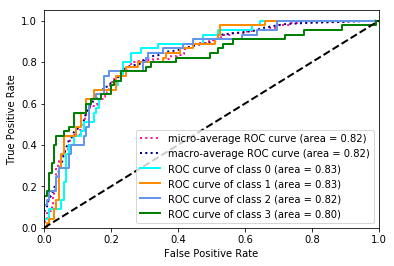

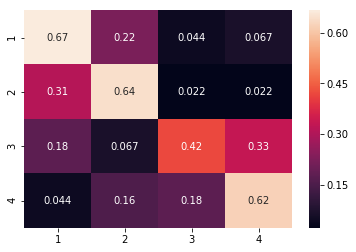

(631200, 60)
(1196, 125, 60)
{'rmse': 2.066666666666667, 'tr_acc': 0.45724907063197023, 'acc': 0.4166666666666667, 'pre': array([0.7       , 0.2       , 0.2       , 0.56666667]), 'rec': array([0.38181818, 0.66666667, 0.46153846, 0.39534884]), 'f1s': array([0.49411765, 0.30769231, 0.27906977, 0.46575342])}
k6b


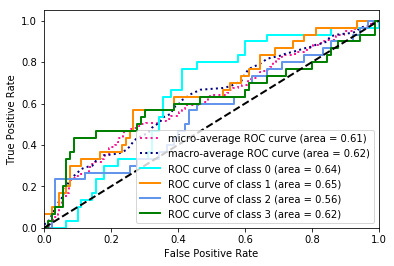

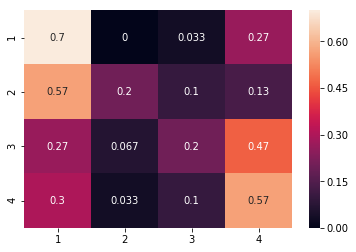

(633430, 60)
(1196, 125, 60)
{'rmse': 1.7333333333333334, 'tr_acc': 0.6784386617100372, 'acc': 0.4083333333333333, 'pre': array([0.3       , 0.4       , 0.43333333, 0.5       ]), 'rec': array([0.52941176, 0.4137931 , 0.35135135, 0.40540541]), 'f1s': array([0.38297872, 0.40677966, 0.3880597 , 0.44776119])}
l1b


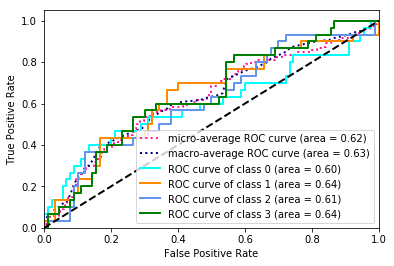

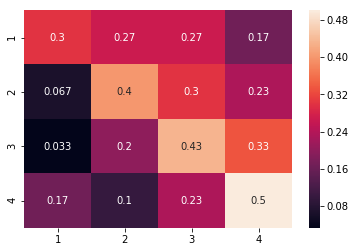

In [13]:
reports = []
for subject in ['k3b', 'k6b', 'l1b']:
    reports.append(evaluate(subject, window_size=125, stride=100))

In [14]:
reports

[{'rmse': 0.9333333333333333,
  'tr_acc': 0.9993811881188119,
  'acc': 0.5888888888888889,
  'pre': array([0.66666667, 0.64444444, 0.42222222, 0.62222222]),
  'rec': array([0.55555556, 0.59183673, 0.63333333, 0.59574468]),
  'f1s': array([0.60606061, 0.61702128, 0.50666667, 0.60869565])},
 {'rmse': 2.066666666666667,
  'tr_acc': 0.45724907063197023,
  'acc': 0.4166666666666667,
  'pre': array([0.7       , 0.2       , 0.2       , 0.56666667]),
  'rec': array([0.38181818, 0.66666667, 0.46153846, 0.39534884]),
  'f1s': array([0.49411765, 0.30769231, 0.27906977, 0.46575342])},
 {'rmse': 1.7333333333333334,
  'tr_acc': 0.6784386617100372,
  'acc': 0.4083333333333333,
  'pre': array([0.3       , 0.4       , 0.43333333, 0.5       ]),
  'rec': array([0.52941176, 0.4137931 , 0.35135135, 0.40540541]),
  'f1s': array([0.38297872, 0.40677966, 0.3880597 , 0.44776119])}]